ResNet
  - Skip connection 이용해서 기울기 소실 문제를해결 100층까지 이상무
  -

VGG
  - 층을 많이 쌓으면 기울기가 0
  - 19층 이상으로 못 올린다.

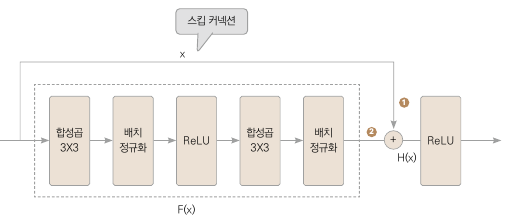

In [2]:
# 자기 자신을미분하면 1이됨 신경망의 출력부분에 입력을 더하는 방식 --> 기울기가 최소 1로 확보
# H(x) = F(x) + x
# skip connection :  은닉층을 거치지 않은 입력값을 은닉층의 출력에 더하는 구조
# 학습이 쉬워진다.?  F(x) = H(x) - x  신경망의 출력과 입력의 차이를 뜻함
# 기존의 학습은 알수없는 미지의 세계로 최소의 값을 찾는 과정
# ResNet  은  0이라는  뚜렸한 목표가 생김
# 이전 은닉층의 정보를 사용하므로 텍스트처리에도 사용

# 단점 : 가중치 증가로 계산량이 많아진다. VGG 에 비해 오버피팅이 증가한다.

배치정규화

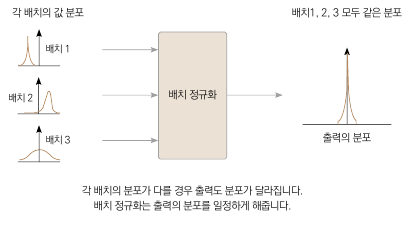

기본 블럭 정의
   - nn.Sequenctial은 단지 조립만 안됨
   - nn.Module을 상속받아서 구현


In [3]:
import torch
import torch.nn as nn

In [7]:
class BasicBlock(nn.Module):
  def __init__(self, int_channel, out_channel, kernel_size=3) -> None:
    super(BasicBlock,self).__init__()
    # 합성곱 정의
    self.c1 = nn.Conv2d(int_channel,out_channel,kernel_size=kernel_size,padding=1)
    self.c2 = nn.Conv2d(out_channel,out_channel,kernel_size=kernel_size,padding=1)
    self.downsample = nn.Conv2d(int_channel,out_channel,kernel_size=1)

    # 배치정규화
    self.b1 = nn.BatchNorm2d(num_features=out_channel)
    self.b2 = nn.BatchNorm2d(num_features=out_channel)

    self.relu = nn.ReLU()

    # 순전파
  def forward(self,x):
    # skip connection을 위해 초기 입력 저장
    x_ = x
    # ResNet 기본 블럭에서 F(x)
    x = self.c1(x)
    x = self.b1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.b2(x)

    x_ = self.downsample(x_)

    x += x_
    x = self.relu(x)

    return x


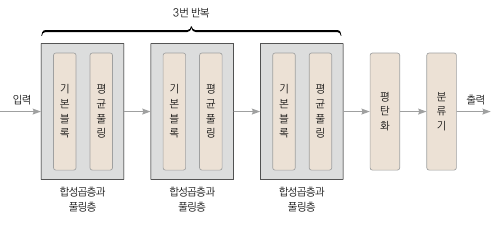

ResNet 모델 정의

In [8]:
class ResNet(nn.Module):
  def __init__(self, num_classes=10) -> None:
    super(ResNet,self).__init__()

    # 기본 블럭 정의
    self.b1 = BasicBlock(3, 64)
    self.b2 = BasicBlock(64,128)
    self.b3 = BasicBlock(128,256)

    # 폴링은 평균폴링
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    # 분류기
    # self.fc1 = nn.Linear
  def forward(self, x):
    x = self.b1(x)
    x = self.pool(x)
    x = self.b2(x)
    x = self.pool(x)
    x = self.b3(x)
    x = self.pool(x)
    x = torch.flatten(x,start_dim=1)
    # 분류기 연결
    return x

In [5]:
import tqdm
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose,ToTensor,Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    Resize(224),
    RandomCrop( (224,224),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2))
])

training_data =  CIFAR10(root='./',train=True,download=True,transform=transforms)
test_data = CIFAR10(root='./',train=False,download=True,transform=transforms)

train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 91834615.31it/s] 


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


학습

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(num_classes=10)
model.to(device)

ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [12]:
# 데이터 모양 확인
temp = model(next(iter(train_loader))[0].to(device))

In [14]:
temp.shape

torch.Size([32, 200704])

In [16]:
class ResNet(nn.Module):
  def __init__(self, num_classes=10) -> None:
    super(ResNet,self).__init__()

    # 기본 블럭 정의
    self.b1 = BasicBlock(3, 64)
    self.b2 = BasicBlock(64,128)
    self.b3 = BasicBlock(128,256)

    # 폴링은 평균폴링
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    # 분류기
    self.fc1 = nn.Linear(in_features=200704, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.b1(x)
    x = self.pool(x)
    x = self.b2(x)
    x = self.pool(x)
    x = self.b3(x)
    x = self.pool(x)
    x = torch.flatten(x,start_dim=1)
    # 분류기 연결
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
import tqdm
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose,ToTensor,Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    Resize(34),
    RandomCrop( (34,34),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2))
])

training_data =  CIFAR10(root='./',train=True,download=True,transform=transforms)
test_data = CIFAR10(root='./',train=False,download=True,transform=transforms)

train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(num_classes=10)
model.to(device)

lr = 1e-4
optim = Adam(model.parameters(),lr=lr)
for epoch in range(2):
  iterloader = tqdm.tqdm(train_loader)
  for data,label in iterloader:
    optim.zero_grad() # 가중치 0 다음계산에 남아있는 가중치를 제거
    # 전방계산 forward
    preds = model(data.to(device))
    loss = nn.CrossEntropyLoss()(preds,label.to(device))
    loss.backward() # 가중치 업데이트
    optim.step() # 가중치 최적화
    # tqdm 출력 업데이트

    iterloader.set_description(f"epoch{epoch} loss{loss.item()}")
torch.save(model.state_dict, "CIFAR_ResNet.pth")

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1563 [00:00<?, ?it/s]

성능평가

In [ ]:
model.load_state_dict(torch.load('CIFAR_ResNet.pth',map_location=device))
num_corr = 0
with torch.no_grad():
  for data, label in test_loader:
    output = model(data.to(device))
    preds = output.data.max(1)[1]  # output.data.max(1) --> np.argmax(output, axis=1)  -- [0] 실제데이터 [1] 인덱스
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr

print(f"Accuracy:{num_corr / len(test_data)}")
